## Project: **Finding Lane Lines on the Road** 
***
In this project, we will use the tools, we learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" to see what the output should look like after using the helper functions below. 


Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'. 
---

**The tools we have are color selection, region of interest selection, GrayScaling, Gaussian Smoothing, Canny Edge Detection and 
Hough Tranform line detection.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Our output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Our goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


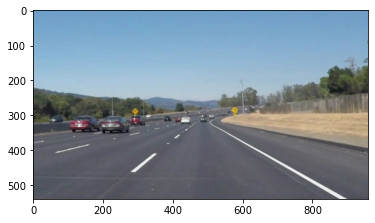

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image


## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
          
    
    #get image shape, this is used for the extrapolation up to the region of interest
    imshape = img.shape
    #initialize empty lists
    left_lines = []
    right_lines = []
    left_lines_aligned = []
    right_lines_aligned = []
    left_m = []
    left_b = []
    right_m = []
    right_b = []

    #loop over the lines and sort them in left and right lists based on the slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            #compute the line slope
            #equation of line is y = m * x + b
            m = (y2-y1)/(x2-x1)
            b = y1 - (m * x1)
            #left line
            if m < 0: left_lines.append((m,b)) 
            #right line    
            if m > 0: right_lines.append((m,b))            
    #calculate the average and standard deviation for the left lines' slope            
    left_m = [line[0] for line in left_lines]
    left_m_avg = np.mean(left_m)
    left_m_std = np.std(left_m)
    
    #only keep lines that are close to the average slope
    for line in left_lines:
        if abs(line[0] - left_m_avg) < left_m_std:
            left_lines_aligned.append(line)
    #compute the average slope and intercept of the aligned left lines
    if len(left_lines_aligned) > 0:
        left_m = [line[0] for line in left_lines_aligned]
        ml = np.mean(left_m)
        left_b = [line[1] for line in left_lines_aligned]
        bl = np.mean(left_b)
    else:
        ml = left_m_avg
        left_b = [line[1] for line in left_lines]
        bl = np.mean(left_b)
    
    #similar logic for the right lines as well
    right_m = [line[0] for line in right_lines]
    right_m_avg = np.mean(right_m)
    right_m_std = np.std(right_m)
   
    for line in right_lines:
        if abs(line[0] - right_m_avg) < right_m_std:
            right_lines_aligned.append(line)            
    if len(right_lines_aligned) > 0:
        right_m = [line[0] for line in right_lines_aligned]
        mr = np.mean(right_m)
        right_b = [line[1] for line in right_lines_aligned]
        br = np.mean(right_b)
    else:
        mr = right_m_avg
        right_b = [line[1] for line in right_lines]
        br = np.mean(right_b)

    #use the previous cycle lines coeficients and smoothen lines over time
    smooth_fact = 0.8
    #only consider computed slope if angled enough
    if (abs(ml) < 1000):
        if (previous_lines[0] != 0):
            ml = previous_lines[0]*smooth_fact + ml*(1-smooth_fact)
            bl = previous_lines[1]*smooth_fact + bl*(1-smooth_fact)
    elif (previous_lines[0] != 0):
        ml = previous_lines[0]
        bl = previous_lines[1]
        
    if (abs(mr) < 1000):      
        if (previous_lines[2] != 0):
            mr = previous_lines[2]*smooth_fact + mr*(1-smooth_fact)
            br = previous_lines[3]*smooth_fact + br*(1-smooth_fact)
    elif (previous_lines[2] != 0):
        mr = previous_lines[2]
        br = previous_lines[3]
            
            
    #interpolate the resulting average line to intersect the edges of the region of interest
    #the two edges consider are y = 6*imshape[0]/10 (the middle edge)
    #y = imshape[0] (the bottom edge)        
    x1l = int((bl - imshape[0]) / (-1 * ml))
    y1l = imshape[0]    
    x2l = int((bl - 6*imshape[0]/10) / (-1 * ml))
    y2l = int(6*imshape[0]/10)      
        
    x1r = int((br - 6*imshape[0]/10) / (-1 * mr))
    y1r = int(6*imshape[0]/10)    
    x2r = int((br - imshape[0]) / (-1 * mr))
    y2r = imshape[0]      
        
    if (x2l < x1r):
        #draw the left line in green and right line in blue
        cv2.line(img, (x1l, y1l), (x2l, y2l), [0, 255, 0], thickness) 
        cv2.line(img, (x1r, y1r), (x2r, y2r), [0, 0, 255], thickness)
    
    #store lines coeficients for next cycle    
    previous_lines[0] = ml
    previous_lines[1] = bl
    previous_lines[2] = mr
    previous_lines[3] = br               
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img



def weighted_img(img, initial_img, α=0.8, β=0.6, γ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build our pipeline to work on the images in the directory "test_images"  
**We should make sure our pipeline works well on these images before we try the videos.**

In [4]:
import os
os.listdir("test_images/")

['.ipynb_checkpoints',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and running our solution on all test_images. Make copies into the `test_images_output` directory, and we can use the images in our report.



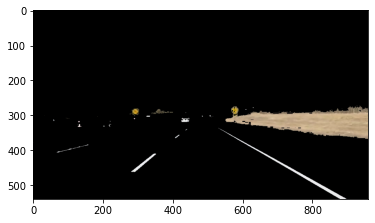

In [5]:
img = mpimg.imread('test_images/solidWhiteCurve.jpg')

### color selection###
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
mask_yellow = cv2.inRange(hsv_img, (15,60,20), (25, 255, 255))
color_mask = cv2.bitwise_or(mask_white, mask_yellow)
masked_img = np.copy(img)
masked_img[color_mask == 0] = [0,0,0]

plt.imshow(masked_img)

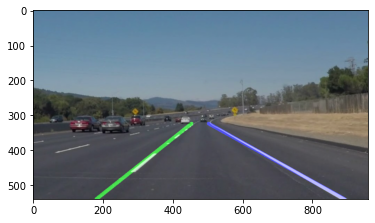

In [6]:
# Build your pipeline that will draw lane lines on the test_images
# Then save them to the test_images_output directory.

previous_lines = [0, 0, 0, 0]
def lane_finding_pipeline(img): 
    
    ### create a color mask ###
    #convert from RGB to HSV
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #define two color masks for yellow and white
    #white mask is applied in RGB color space, it's easier to tune the values
    #values from 200 to 255 on all colors are picked from trial and error
    
    mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
    
    #yellow mask is done in HSV color space since it's easier to identify the hue of a certain color
    #values from 15 to 25 for hue and above 60 for saturation are picked from trial and error
    
    mask_yellow = cv2.inRange(hsv_img, (15,60,20), (25, 255, 255))
    
    #combine the two masks, both yellow and white pixels are of interest
    
    color_mask = cv2.bitwise_or(mask_white, mask_yellow)
    
    #make a copy of the original image
    
    masked_img = np.copy(img)
    
    #pixels that are not part of the mask(neither white or yellow) are made black
    
    masked_img[color_mask == 0] = [0,0,0]
    
    ### smoothen image ###
    #Turn the masked image to grayscale for easier processing
    
    gray_img = grayscale(masked_img)
    
    #To get rid of imperfections, apply the gaussian blur
    #kernel chosen 5, no other values are changed the implicit ones work just fine
    
    kernel_size = 5
    blurred_gray_img = gaussian_blur(gray_img, kernel_size)

    ### Detect edges ###
    #choose values for te Canny edge detection filter
    #for the differentioal value threshold chosen is 150 which is pretty high given that the max difference between
    #black and white is 255
    #low threshold of 50 which takes adjacent differential of 50 pixels as part of the edge
    
    low_threshold = 50
    high_threshold = 150
    edges_from_img = canny(blurred_gray_img, low_threshold, high_threshold)

    ### select region of interest###
    #define a polygon that should frame the road given that the camera is in a fixed position
    #polygon covers the bottom left and bottom right points of the picture
    #with the other two top points it forms a trapezoid that points towards the center of the image
    #the polygon is relative to the image's size
    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(4*imshape[1]/9, 6*imshape[0]/10), (5*imshape[1]/9, 6*imshape[0]/10), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_from_img, vertices)

    ### Find lines from edges pixels ###
    #define parameters for the Hough transform
    
    #Hough grid resolution in pixels
    rho = 2
    #Hough grid angular resolution in radians 
    theta = np.pi/180 
    #minimum number of sines intersecting in a cell, collinear points to form a line
    threshold = 15
    #minimum length of a line in pixels
    min_line_len = 10 
    #maximum gap in pixels between segments to be considered part of the same line 
    max_line_gap = 5    
    #apply Hough transform to color masked grayscale blurred image
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    ### overlay image and lines ###
    #add lines on top of the original image
    #the lines are a bit transparent so the lane lines from the pictures still show for visual confirmation
    overlay_img = weighted_img(line_img, img)
    
    return overlay_img

img = mpimg.imread('test_images/solidWhiteCurve.jpg')
img_out = lane_finding_pipeline(img)
plt.imshow(img_out)
previous_lines = [0, 0, 0, 0]

## Test on Videos

Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    result = lane_finding_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
previous_lines = [0, 0, 0, 0]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 6.02 s
Wall time: 8.37 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point,  we are successful in  making the pipeline and tuning parameters, we probably have the Hough line segments drawn onto the road, we have  identified the full extent of the lane and marking it clearly as in the example video (solidYellowLeft.mp4). We have identified,  the full length of the visible lane based on the line segments  with the help of Hough Transform. As mentioned previously, we try to average and/or extrapolate the line segments that we've detected on map out the full extent of the lane lines. As an example of the result we're going for in the video "solidYellowLeft.mp4".**

**We modify draw_lines function accordingly and try re-running the pipeline. The new output  draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines  start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
previous_lines = [0, 0, 0, 0]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))